# Preprocess confined inputs (km105, PSAD)

Generate grid-aligned arrays for the confined model using the km105 catchment. Outputs are written under `mountain/prepared/` so downstream notebooks can consume them without touching the old psad folder.

In [11]:
from pathlib import Path
import numpy as np
import geopandas as gpd
from flopy.utils import Raster
from flopy.discretization import StructuredGrid
from flopy.utils.gridintersect import GridIntersect

# Paths
mountain_dir = Path('/home/jec18/modflow/jupy/VUB/mountain')
reproj_rasters = mountain_dir / 'reprojected' / 'rasters'
reproj_vectors = mountain_dir / 'reprojected' / 'vectors'
prepared_dir = mountain_dir / 'prepared'
prepared_dir.mkdir(exist_ok=True)

# Base dataset root (original psad); used for recharge/ET if scaled rasters not present
psad_root = Path('/home/jec18/datasets/gw/psad')

# Inputs
catchment_path = Path('/home/jec18/catchments/km105.shp')
recharge_monthly_scaled = prepared_dir / 'recharge_m_FD_jules_scaled.tif'
recharge_annual_scaled = prepared_dir / 'recharge_FD_jules_scaled.tif'

# Fallback to original rasters when scaled versions are missing
recharge_monthly_path = recharge_monthly_scaled if recharge_monthly_scaled.exists() else psad_root / 'recharge_m_FD_jules.tif'
recharge_annual_path = recharge_annual_scaled if recharge_annual_scaled.exists() else psad_root / 'recharge_FD_jules.tif'

# Hydro/geo rasters (use psad defaults; geology_k_psad is available but keep hydro conds consistent with prior workflow)
hk1_path = psad_root / 'hk1.tif'
hk2_path = psad_root / 'hk2.tif'
deposits_path = psad_root / 'hk_deposits.tif'
bedrock_path = psad_root / 'hk_bedrock.tif'

# DEM: use clipped DEM if available, else psad full
dem_path = reproj_rasters / 'dem_sa_clip_psad.tif'
if not dem_path.exists():
    dem_path = psad_root / 'dem_con.tif'

output_npz = prepared_dir / 'preprocessed_confined_inputs.npz'
print('Output NPZ ->', output_npz)


Output NPZ -> /home/jec18/modflow/jupy/VUB/mountain/prepared/preprocessed_confined_inputs.npz


## Build model grid from km105 (buffered 5 km, 300 m resolution)
- Reproject catchment to PSAD (EPSG:24893)
- Create buffered bounding box
- Define StructuredGrid and idomain mask

In [12]:
km105 = gpd.read_file(catchment_path)
if km105.crs is None:
    km105 = km105.set_crs(epsg=4326)
km105 = km105.to_crs(epsg=24893)
km105_geom = km105.geometry.union_all()
if not km105_geom.is_valid:
    km105_geom = km105_geom.buffer(0)

resolution = 300
buffer = 5000
minx, miny, maxx, maxy = km105_geom.bounds
xmin = np.floor(minx / resolution) * resolution - buffer
ymin = np.floor(miny / resolution) * resolution - buffer
xmax = np.ceil(maxx / resolution) * resolution + buffer
ymax = np.ceil(maxy / resolution) * resolution + buffer

ncol = int(np.ceil((xmax - xmin) / resolution))
nrow = int(np.ceil((ymax - ymin) / resolution))
delr = resolution * np.ones(ncol, dtype=float)
delc = resolution * np.ones(nrow, dtype=float)

top = np.full((nrow, ncol), 1.0)
botm = np.full((1, nrow, ncol), 0.0)

struct_grid = StructuredGrid(
    nlay=1,
    delr=delr,
    delc=delc,
    xoff=xmin,
    yoff=ymin,
    top=top,
    botm=botm,
)
ix = GridIntersect(struct_grid)
result = ix.intersect(km105_geom, shapetype='polygon')
cell_tuples = [tuple(int(c) for c in cid) for cid in result.cellids]
idx = np.array(cell_tuples, dtype=int)
idomain = np.zeros(struct_grid.shape[1:], dtype=int)
idomain[tuple(idx[:, i] for i in range(idx.shape[1]))] = 1
struct_grid.idomain = idomain.reshape(struct_grid.shape)
print('Grid shape:', struct_grid.shape)


/home/jec18/hydro1/anaconda3/envs/gmdsitut/lib/python3.11/site-packages/flopy/utils/gridintersect.py:123: DeprecationWarning: Note `method="structured"` is deprecated. Pass `method="vertex"` to silence this warning. This will be the new default in a future release and this keyword argument will be removed.
  warnings.warn(


Grid shape: (1, 608, 678)


## Load and resample rasters to grid
Uses `flopy.utils.Raster` for consistency with prior workflow. Recharge/ET use scaled rasters if present; otherwise fall back to psad originals.

In [13]:
dem = Raster.load(str(dem_path))
hk1 = Raster.load(str(hk1_path))
hk2 = Raster.load(str(hk2_path))
recharge_monthly = Raster.load(str(recharge_monthly_path))
recharge_annual = Raster.load(str(recharge_annual_path))
deposits_ras = Raster.load(str(deposits_path))
bedrock_ras = Raster.load(str(bedrock_path))

print('Resampling rasters to structured grid...')
topo = dem.resample_to_grid(struct_grid, band=1, method='linear', extrapolate_edges=True)
k_h_data = hk1.resample_to_grid(struct_grid, band=1, method='nearest')
k_h_data2 = hk2.resample_to_grid(struct_grid, band=1, method='nearest')
deposits = deposits_ras.resample_to_grid(struct_grid, band=1, method='nearest')
bedrock = bedrock_ras.resample_to_grid(struct_grid, band=1, method='nearest')

recharge_data = np.zeros((13, struct_grid.nrow, struct_grid.ncol), dtype=np.float32)
recharge_data[0] = recharge_annual.resample_to_grid(struct_grid, band=1, method='linear')
for month in range(12):
    recharge_data[month + 1] = recharge_monthly.resample_to_grid(
        struct_grid, band=month + 1, method='linear'
    )

print('Resampling complete.')


Resampling rasters to structured grid...
Resampling complete.


## Quick visual checks
Preview key arrays with colorbars (topography, K fields, geology flags, recharge/ET examples, idomain).

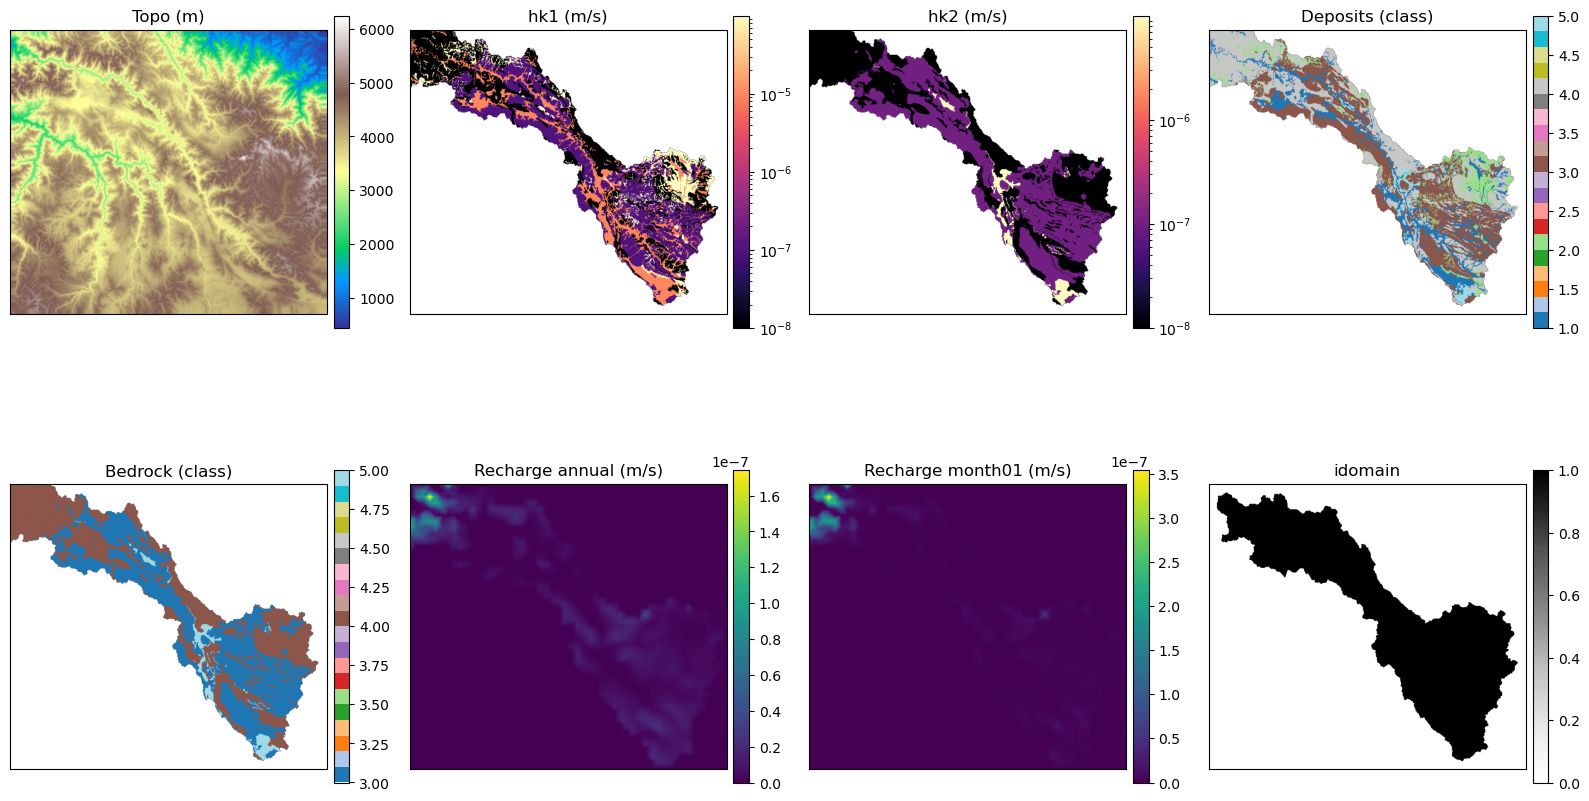

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

extent = (xmin, xmin + ncol * resolution, ymin, ymin + nrow * resolution)

def log_norm(arr, floor=1e-12):
    arr_pos = arr[arr > 0]
    if arr_pos.size == 0:
        return None
    vmin = max(arr_pos.min(), floor)
    vmax = arr_pos.max()
    return LogNorm(vmin=vmin, vmax=vmax)

plots = [
    (topo, 'Topo (m)', 'terrain', None),
    (k_h_data, 'hk1 (m/s)', 'magma', log_norm(k_h_data)),
    (k_h_data2, 'hk2 (m/s)', 'magma', log_norm(k_h_data2)),
    (deposits, 'Deposits (class)', 'tab20', None),
    (bedrock, 'Bedrock (class)', 'tab20', None),
    (recharge_data[0], 'Recharge annual (m/s)', 'viridis', None),
    (recharge_data[1], 'Recharge month01 (m/s)', 'viridis', None),
    (struct_grid.idomain[0], 'idomain', 'Greys', None),
]

nrows = 2
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 10))
for ax, item in zip(axes.ravel(), plots + [None] * (nrows * ncols - len(plots))):
    if item is None:
        ax.axis('off')
        continue
    arr, title, cmap, norm = item
    im = ax.imshow(arr, origin='upper', cmap=cmap, norm=norm)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)

plt.tight_layout()
plt.show()


## Save preprocessed NPZ
Stores arrays in `mountain/prepared/preprocessed_confined_inputs.npz` for downstream transient/steady runs.

In [15]:
np.savez_compressed(
    output_npz,
    topo=topo.astype(np.float32),
    k_h_data=k_h_data.astype(np.float32),
    k_h_data2=k_h_data2.astype(np.float32),
    recharge_data=recharge_data,
    deposits=deposits.astype(np.int16),
    bedrock=bedrock.astype(np.int16),
    idomain=struct_grid.idomain.astype(np.int8),
    resolution=np.array(resolution, dtype=np.int32),
    xmin=np.array(xmin, dtype=np.float64),
    ymin=np.array(ymin, dtype=np.float64),
    nrow=np.array(struct_grid.nrow, dtype=np.int32),
    ncol=np.array(struct_grid.ncol, dtype=np.int32)
)
print('Saved NPZ with datasets:')
with np.load(output_npz) as data:
    for key in data.files:
        arr = data[key]
        print(f"  {key}: shape={arr.shape} dtype={arr.dtype}")


Saved NPZ with datasets:
  topo: shape=(608, 678) dtype=float32
  k_h_data: shape=(608, 678) dtype=float32
  k_h_data2: shape=(608, 678) dtype=float32
  recharge_data: shape=(13, 608, 678) dtype=float32
  deposits: shape=(608, 678) dtype=int16
  bedrock: shape=(608, 678) dtype=int16
  idomain: shape=(1, 608, 678) dtype=int8
  resolution: shape=() dtype=int32
  xmin: shape=() dtype=float64
  ymin: shape=() dtype=float64
  nrow: shape=() dtype=int32
  ncol: shape=() dtype=int32
